In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib

%matplotlib inline

In [2]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing raw subject data
path = r'C:\Users\andre\Documents\DOD Data'
#---------------------------------------------------------------------------------------------------------

complete = list(['MVC', 'Pavement', 'Crosswalk Test'])

def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of all activities separated by trial, sensor location, and accelerometer + gyroscope
#                     or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = pd.read_csv(os.path.join(path, 'annotations.csv')).set_index('EventType')
    del timestamps['Timestamp (ms)']
    del timestamps['AnnotationId']
    del timestamps['AuthorId']
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            if filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps

def plot_data(acts, activity, trial, sensor, data, start=0, end=500):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot()

In [3]:
Subjects = {IDs.lower(): pd.DataFrame() for IDs in os.listdir(path)}

for ID in Subjects:
    act_dict, timestamps = extract_data(ID, os.path.join(path, ID))
    
    Subjects[ID] = act_dict

In [4]:
Subjects['pka01']

{'Crosswalk Test': {0: {'flexor_digitorum_left': {'accel':                 Accel X (g)  Accel Y (g)  Accel Z (g)
    Timestamp (ms)                                       
    1482350520911     -0.982864    -0.072206     0.279850
    1482350520943     -0.974075    -0.068788     0.280339
    1482350520974     -0.984329    -0.076112     0.248600
    1482350521006     -0.974563    -0.071229     0.250065
    1482350521037     -0.968704    -0.077577     0.267643
    1482350521069     -0.994583    -0.081483     0.261784
    1482350521100     -0.991653    -0.059510     0.280339
    1482350521132     -0.959915    -0.070253     0.268132
    1482350521163     -0.973098    -0.076600     0.263249
    1482350521195     -0.974075    -0.068788     0.265690
    1482350521226     -0.969192    -0.076600     0.262272
    1482350521258     -0.979446    -0.080995     0.242741
    1482350521289     -0.967727    -0.061952     0.247623
    1482350521321     -0.965774    -0.058045     0.273503
    1482350521352

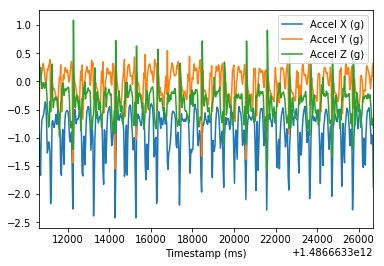

In [5]:
acts = Subjects['pka03']
plot_data(acts, 'Pavement', 0, 'd14spk18', 'accel')

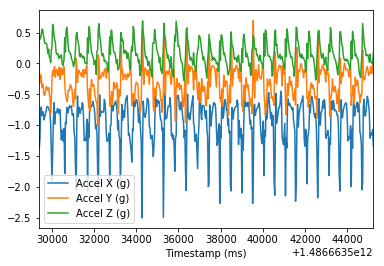

In [6]:
plot_data(acts, 'Pavement', 1, 'd5la7wyb', 'accel')